#### Object Detection Using Neural Networks
This notebook uses the version of Faster R-CNN that uses a Resnet network as its backbone and also includes a  Feature Pyramid Network.

In [124]:
#Importing some improtant libraries that we will use wot wowrk with 
import numpy as np
import torch 
import torchvision
from torchvision import transforms as T
import cv2
from PIL import Image
from matplotlib import pyplot as plt
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.detection.faster_rcnn import fasterrcnn_resnet50_fpn

#load model pre-trained on COCO
model = fasterrcnn_resnet50_fpn(pretrained =  True)

#this makes sure we are using the modle in inference mode
model.eval()


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## How to Load image
We can use the PIL library to easily load images 

In [178]:
# Loading Test image to run inference
test_img = Image.open("testimg1.jpg")
# converting image to Pytorch tensors to run inference
transform = T.ToTensor()
test_tensor = transform(test_img) 

And run an inference on the image as follows

In [126]:
# torch.no_grad() is used as we aren't training the model, just running an inference
with torch.no_grad():
    pred = model([test_tensor])


# What objects is the network looking for?
The Faster R-CNN model we are using in this notebook contains a RESNET backbone which is trained on the Common Objects in Context (COCO) dataset. COCO contains over 330K images and 91 categories. Some example categories are "person", surfboard", "bottle" and "plates" etc. The full list of calss labels are stored in the array coc_names

In [222]:
# Function to draw bounding boxes around an image
def drawBoundingBoxLabels(img, prediction, **kwargs):
    coco_names = ["person" , "bicycle" , "car" , "motorcycle" , "airplane" , "bus" , "train" , "truck" , "boat" , "traffic light" , "fire hydrant" ,"street sign" , "stop sign" ,
               "parking meter" , "bench" , "bird" , "cat" , "dog" , "horse" , "sheep" , "cow" , "elephant" , "bear" , "zebra" , "giraffe" , "hat" , "backpack" , "umbrella" ,
                "shoe" , "eye glasses" , "handbag" , "tie" , "suitcase" , "frisbee" , "skis" , "snowboard" , "sports ball" , "kite" , "baseball bat" , "baseball glove" , 
                "skateboard" , "surfboard" , "tennis racket" , "bottle" , "plate" , "wine glass" , "cup" , "fork" , "knife" , "spoon" , "bowl" , "banana" , "apple" , "sandwich" ,
                "orange" , "broccoli" , "carrot" , "hot dog" ,"pizza" , "donut" , "cake" , "chair" , "couch" , "potted plant" , "bed" ,"mirror" , "dining table" , "window" , 
                "desk" , "toilet" , "door" , "tv" ,"laptop" , "mouse" , "remote" , "keyboard" , "cell phone" , "microwave" ,"oven" , "toaster" , "sink" , "refrigerator" , 
                "blender" , "book" ,"clock" , "vase" , "scissors" , "teddy bear" , "hair drier" , "toothbrush" , "hair brush"]
    # set font
    font = cv2.FONT_HERSHEY_SIMPLEX

    # obtain only boxes above thresh hold
    bboxes, labels, scores = prediction[0]["boxes"], prediction[0]["labels"], prediction[0]["scores"]
    #check if threshold needed
    if "threshold" in kwargs.keys():
        threshold = kwargs["threshold"]
    
        bboxes = bboxes[scores >= threshold]
        labels = labels[scores >= threshold]
        scores = scores[scores >= threshold]
    if "uncertain" in kwargs.keys():
        threshold = 0.1
        bboxes = bboxes[scores <= threshold]
        labels = labels[scores <= threshold]
        scores = scores[scores <= threshold]
    igg =  img #cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #find out unique classes and generate color for each
    uq_labels  = torch.unique(labels)
    color_scheme = {}
    for i in uq_labels:
        color_scheme[coco_names[i-1]] = tuple(np.random.randint(0,256) for _ in range(3))
    

    for i in range(bboxes.shape[0]):
        box = bboxes[i]
        class_name = coco_names[labels.numpy()[i]-1]
        igg = cv2.rectangle(igg,
                    (int(box[0]), int(box[1])),
                    (int(box[2]), int(box[3])),
                    color_scheme[class_name], 4)
        igg = cv2.putText(igg, class_name, (int(box[0]), int(box[1]) -10), font, 2, color_scheme[class_name], 2, cv2.LINE_AA)
        
    return igg
 

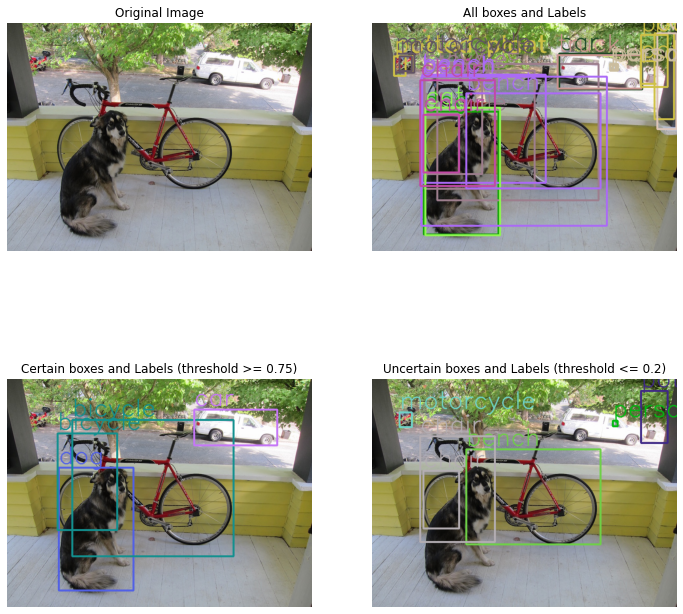

In [225]:
# Class labels that are predicted.
imgNoThreshold = drawBoundingBoxLabels(np.array(test_img), pred)
imgThreshold = drawBoundingBoxLabels(np.array(test_img), pred, threshold = 0.75)
imgThresholdUndcertain = drawBoundingBoxLabels(np.array(test_img), pred, uncertain = 1)

#plot side by side
plt.figure(figsize= (12,12))

#tile 1
plt.subplot(2,2,1)
plt.axis("off")
plt.imshow(test_img)
plt.title("Original Image")

#tile 2
plt.subplot(2,2,2)
plt.axis("off")
plt.imshow(imgNoThreshold)
plt.title("All boxes and Labels")

#tile 3
plt.subplot(2,2,3)
plt.axis("off")
plt.imshow(imgThreshold)
plt.title("Certain boxes and Labels (threshold >= 0.75)")

#tile 4
plt.subplot(2,2,4)
plt.axis("off")
plt.imshow(imgThresholdUndcertain)
plt.title("Uncertain boxes and Labels (threshold <= 0.2)")

plt.show()


In [228]:
# figures can easily be saved using the following function
def saveMyImage(nparray, name):
    img = Image.fromarray(nparray, "RGB")
    name = name + ".jpeg"
    img.save(name)

saveMyImage(imgNoThreshold, "nothreshimg")
saveMyImage(imgThreshold, "threshimg")
saveMyImage(imgThresholdUndcertain, "uncertainimg")



In [144]:
## Obtain intermediate layer
outputs = []
model.eval()
hook = model.rpn.anchor_generator.register_forward_hook(
    lambda self, input, output: outputs.append(output))

with torch.no_grad():
    res = model([test_tensor])
hook.remove()


# Visualizing Anchor Boxes 
The RPN network of Faster R-CNN generates 9 anchor boxes at 3 scales and 3 aspect ratios for each anchor point. An anchor point is a pixel of an intermediate layer in the RESNET50 backbone. Some of these anchor boxes are show below. Note that alothough the anchor points are generated from the featuremap of an intermediate layer, the anchor boxes are projected back onto the original image. The RPN is a fully convolutional layer, it supplies the next layer "suggestions" on where to look for objects of interest and where there is no object i.e an "objectness" score. The layer classifies all anchorboxes based on their IoU with ground truth bounding boxes, then randomly samples these bounding boxes for positive boxes (containing object) and negative boxes (background). These outputs are used in calculating loss of the function aswell. 

For each image 217413 anchor boxes are generated


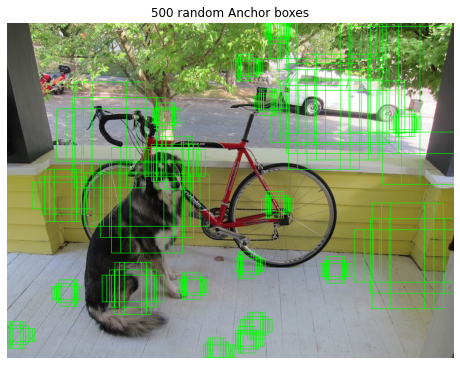

In [145]:
iggAnchor = cv2.imread("testimg1.jpg")
iggAnchor = cv2.cvtColor(iggAnchor, cv2.COLOR_BGR2RGB)
anchorBoxes = np.array(outputs[0][0])
randIdx = np.random.randint(0,anchorBoxes.shape[0], (50))
print( "For each image {} anchor boxes are generated".format(anchorBoxes.shape[0]))

for i in randIdx:
    for j in range(9):
        box = anchorBoxes[i+j,:]
        igg = cv2.rectangle(iggAnchor,
                    (int(box[0]), int(box[1])),
                    (int(box[2]), int(box[3])),
                    (0, 255, 0), 1)
plt.figure(figsize = (8,8))
plt.title("500 random Anchor boxes")
plt.axis('off')
plt.imshow(iggAnchor)


# Advantages of using Regin Proposal Network 

In [148]:
## Obtain output of RPN layer
outputs = []
model.eval()
hook = model.rpn.head.cls_logits.register_forward_hook(
    lambda self, input, output: outputs.append(output))

with torch.no_grad():
    res = model([test_tensor])
hook.remove()

In [147]:
print(len(outputs))

1


In [123]:
outputs[1].shape


torch.Size([1, 3, 100, 136])

In [99]:
## Obtain output of RPN layer
outputs = []
model.eval()
hook = model.rpn.head .cls_logits.register_forward_hook(
    lambda self, input, output: outputs.append(output))

with torch.no_grad():
    res = model([test_tensor])
hook.remove()